===============================================================================Starts

In [5]:
# TCA 05/28

# encoding=utf-8
#CPU prediction TL

"""
    Created on 22.52 2023/10/18
    @author: dan
"""
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import scipy.io
import scipy.linalg
import os
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier


def load_csv(src_domain, tar_domain):
  norm_scaler = MinMaxScaler()
  dfs = pd.read_csv(src_domain)
  dft = pd.read_csv(tar_domain)
  dfs = dfs.sample(frac = 1)
  dft = dft.sample(frac = 1)
  labels=['CPU']#CPU MEM LINK
  predictors = list(set(list(dfs.columns))-set(labels))
  norm_Xs = norm_scaler.fit_transform(dfs[predictors])
  norm_Xt = norm_scaler.fit_transform(dft[predictors])#normalization

  #norm_Xs.dropna(axis=0)
  dfs[labels].dropna(axis=0)
  #norm_Xt.dropna(axis=0)
  dft[labels].dropna(axis=0)

  Xs = norm_Xs
  Ys = dfs[labels].values
  Xt = norm_Xt
  Yt = dft[labels].values
  return Xs, Ys, Xt, Yt


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=8, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    # def fit_predict(self, Xs, Ys, Xt, Yt):
    #     '''
    #     Transform Xs and Xt, then make predictions on target using 1NN
    #     :param Xs: ns * n_feature, source feature
    #     :param Ys: ns * 1, source label
    #     :param Xt: nt * n_feature, target feature
    #     :param Yt: nt * 1, target label
    #     :return: Accuracy and predicted_labels on the target domain
    #     '''
    #     Xs_new, Xt_new = self.fit(Xs, Xt)
    #     clf = KNeighborsClassifier(n_neighbors=1) #fit here and train, then predict
    #     clf.fit(Xs_new, Ys.ravel())
    #     y_pred = clf.predict(Xt_new)
    #     acc = sklearn.metrics.accuracy_score(Yt, y_pred)
    #     return acc, y_pred, Xs_new, Xt_new


if __name__ == "__main__":
    src_domain = 'Inline_generated.csv'
    tar_domain = 'Passive.csv'
    Xs, Ys, Xt, Yt = load_csv(src_domain, tar_domain)
    print('Source:', src_domain, Xs.shape, Ys.shape)
    print('Target:', tar_domain, Xt.shape, Yt.shape)

    tca = TCA(kernel_type='primal', dim=8, lamb=0.1, gamma=1)##########################change dim here
    Xs_new, Xt_new = tca.fit(Xs, Xt)
    # acc, ypre, Xsnew, Xtnew = tca.fit_predict(Xs, Ys, Xt, Yt)
    # print(f'Accuracy : {acc:.9f}')

Source: Inline_generated.csv (2000, 8) (2000, 1)
Target: Passive.csv (774, 8) (774, 1)


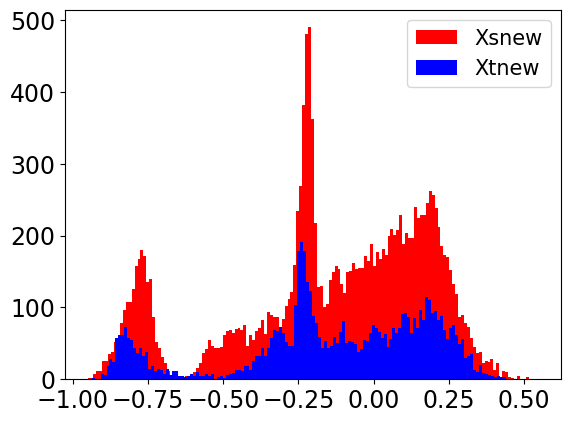

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXsnew = Xs_new.flatten()
img_flatXtnew = Xt_new.flatten()
#img_flatXtnew = np.random.choice(img_flatXtnew, 2200, replace=False)
#img_flatXsnew = np.random.choice(img_flatXsnew, 8888, replace=False)
n_bins = 150
xsnew_draw = [img_flatXsnew]
xtnew_draw = [img_flatXtnew]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
# colors = [ 'blue','red']
# labels = [ 'Xtnew','Xsnew']
plt.hist(xsnew_draw, n_bins, histtype='bar', stacked=True, color='red', label='Xsnew')
plt.hist(xtnew_draw, 150, histtype='bar', stacked=True, color='blue', label='Xtnew')
plt.legend(prop={'size': 15})
#plt.title('Probability Density after TCA')
plt.savefig('TCA_feature_distribution.pdf', bbox_inches='tight')
plt.show()

Xs, Ys; Xt, Yt; Xs_new, Ys ;  Xt_new. Yt

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


~~~~Poly MAtrix~~~~~~
Results of sklearn.metrics of Poly:
MAE Poly: 0.13319979855769878
MSE Poly: 0.028074571596996816
RMSE Poly: 0.1675546824084508
R-Squared Poly: 0.7073301379561975
######################
~~~~SVR MAtrix~~~~~~
Results of sklearn.metrics of SVR:
MAE SVR: 0.13827348240568674
MSE SVR: 0.030431268153247162
RMSE SVR: 0.17444560227545766
R-Squared SVR: 0.6827622098717427
######################
~~~~MLP MAtrix~~~~~~
Results of sklearn.metrics of MLP:
MAE MLP: 0.1333789861439558
MSE MLP: 0.027276991542496604
RMSE MLP: 0.16515747498220176
R-Squared MLP: 0.7156446956231945
######################
~~~~RF MAtrix~~~~~~
Results of sklearn.metrics of RF:
MAE RF: 0.1582507895492391
MSE RF: 0.03832064272498163
RMSE RF: 0.19575659050203553
R-Squared RF: 0.6005176007405243
######################


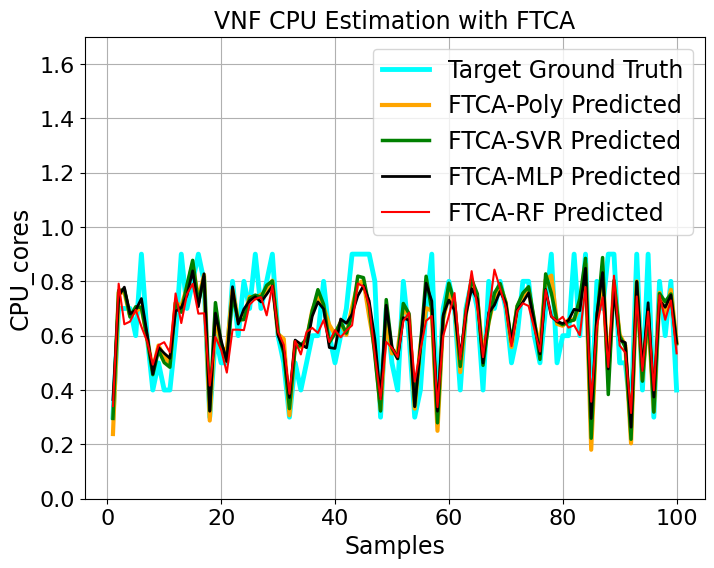

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan The Lable is MEM 算MAERMSE等指标的时候，不用可视化，把yt，ys 都minmax了就行，可视化不用minmax yt
"""
#######
# Step 1 - Load TCA Data
######################################
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

# Initialize MinMaxScaler

minmax_y = MinMaxScaler()

minmax_yt = MinMaxScaler()#######

# Fit and transform the training data
X = Xs_new
y = minmax_y.fit_transform(Ys)

yt = minmax_yt.fit_transform(Yt)#######

x_t = Xt_new

x_t = x_t[0:100,:]
y_t = Yt[0:100,:]
#######################################
#Step2 Load Benchmark Origional Data

Xs = Xs
Xt = Xt[0:100,:]

################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)

################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X, y)

################################
### MLP Regression ###
################################
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(10, 100),
    alpha=0.001, #regularization part
    early_stopping=False,
    max_iter=150
)
#
# Train the model
#
nn.fit(X, y)
####bench mark####


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y.ravel())

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))
plt.ylim(0, 1.7)

plt.plot(X_axis, y_t,color="cyan",label='Target Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

y_pol_pred = minmax_y.inverse_transform(poly_regressor.predict(poly_features.fit_transform(x_t)))

y_svr_pred = minmax_y.inverse_transform(svr_regressor.predict(x_t).reshape(-1, 1))

y_nn_pred = minmax_y.inverse_transform(nn.predict(x_t).reshape(-1, 1))

y_RF_pred = minmax_y.inverse_transform(forest_regressor.predict(x_t).reshape(-1, 1))

####################evalucation matrics here
y_pol_pred_val = poly_regressor.predict(poly_features.fit_transform(Xt_new))

y_svr_pred_val = svr_regressor.predict(Xt_new).reshape(-1, 1)

y_nn_pred_val = nn.predict(Xt_new).reshape(-1, 1)

y_RF_pred_val = forest_regressor.predict(Xt_new).reshape(-1, 1)

###################################################Pol
mae_poly = metrics.mean_absolute_error(yt, y_pol_pred_val)
mse_poly = metrics.mean_squared_error(yt, y_pol_pred_val)
rmse_poly = np.sqrt(mse_poly)
r2_poly = metrics.r2_score(yt,y_pol_pred_val)
print('~~~~Poly MAtrix~~~~~~')
print("Results of sklearn.metrics of Poly:")
print("MAE Poly:",mae_poly)
print("MSE Poly:", mse_poly)
print("RMSE Poly:", rmse_poly)
print("R-Squared Poly:", r2_poly)
print('######################')
#########################################

###################################################SVR
mae_svr = metrics.mean_absolute_error(yt, y_svr_pred_val)
mse_svr = metrics.mean_squared_error(yt, y_svr_pred_val)
rmse_svr = np.sqrt(mse_svr)
r2_svr = metrics.r2_score(yt,y_svr_pred_val)
print('~~~~SVR MAtrix~~~~~~')
print("Results of sklearn.metrics of SVR:")
print("MAE SVR:",mae_svr)
print("MSE SVR:", mse_svr)
print("RMSE SVR:", rmse_svr)
print("R-Squared SVR:", r2_svr)
print('######################')
#########################################

###################################################DT
mae_nn = metrics.mean_absolute_error(yt, y_nn_pred_val)
mse_nn = metrics.mean_squared_error(yt, y_nn_pred_val)
rmse_nn = np.sqrt(mse_nn)
r2_nn = metrics.r2_score(yt,y_nn_pred_val)
print('~~~~MLP MAtrix~~~~~~')
print("Results of sklearn.metrics of MLP:")
print("MAE MLP:",mae_nn)
print("MSE MLP:", mse_nn)
print("RMSE MLP:", rmse_nn)
print("R-Squared MLP:", r2_nn)
print('######################')
#########################################

###################################################RF
mae_RF = metrics.mean_absolute_error(yt, y_RF_pred_val)
mse_RF = metrics.mean_squared_error(yt, y_RF_pred_val)
rmse_RF = np.sqrt(mse_RF)
r2_RF = metrics.r2_score(yt,y_RF_pred_val)
print('~~~~RF MAtrix~~~~~~')
print("Results of sklearn.metrics of RF:")
print("MAE RF:",mae_RF)
print("MSE RF:", mse_RF)
print("RMSE RF:", rmse_RF)
print("R-Squared RF:", r2_RF)
print('######################')
#########################################
####################

plt.plot(X_axis, y_pol_pred, color="orange",label='FTCA-Poly Predicted',lw=3.0)
#plt.plot(X_axis, poly_regressor_2.predict(poly_features_2.fit_transform(Xt)), color="orange",label='Poly Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, y_svr_pred, color="green",label='FTCA-SVR Predicted',lw=2.5)
#plt.plot(X_axis, svr_regressor_2.predict(Xt),color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, y_nn_pred, color="black",label='FTCA-MLP Predicted',lw = 2)
#plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

plt.plot(X_axis, y_RF_pred, color="red",label='FTCA-RF Predicted',lw=1.5)


plt.rcParams['font.size'] = 17
plt.title("VNF CPU Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("CPU_cores",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

plt.legend(loc='best')
plt.savefig('Regression compare_CPU.pdf', bbox_inches='tight')
plt.show()

=================================================


In [ ]:
# encoding=utf-8
#CPU prediction without TL

"""
    Created on 16.29 2023/11/09
    @author: dan
"""
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import scipy.io
import scipy.linalg
import os
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

src_domain = 'Inline.csv'
tar_domain = 'Passive.csv'

norm_scaler = MinMaxScaler()
dfs = pd.read_csv(src_domain)
dft = pd.read_csv(tar_domain)
dfs = dfs.sample(frac = 1)
dft = dft.sample(frac = 1)
labels=['CPU']#CPU MEM LINK
predictors = list(set(list(dfs.columns))-set(labels))
norm_Xs = norm_scaler.fit_transform(dfs[predictors])
norm_Xt = norm_scaler.fit_transform(dft[predictors])#normalization

#norm_Xs.dropna(axis=0)
dfs[labels].dropna(axis=0)
#norm_Xt.dropna(axis=0)
dft[labels].dropna(axis=0)

Xs = norm_Xs
Ys = dfs[labels].values
Xt = norm_Xt
Yt = dft[labels].values

minmax_ys = MinMaxScaler()
minmax_yt = MinMaxScaler()#######

ys = minmax_ys.fit_transform(Ys)
yt = minmax_yt.fit_transform(Yt)#######

################################Training
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(Xs)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, ys)

################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(Xs, ys)


################################
### MLP Regression ###
################################
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(10, 100),
    alpha=0.001, #regularization part
    early_stopping=False,
    max_iter=150
)
#
# Train the model
#
nn.fit(Xs, ys)
####bench mark####


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(Xs, ys.ravel())


##############################Test
####################evalucation matrics here
y_pol_pred_oFTCA = poly_regressor.predict(poly_features.fit_transform(Xt))

y_svr_pred_oFTCA = svr_regressor.predict(Xt).reshape(-1, 1)

y_nn_pred_oFTCA = nn.predict(Xt).reshape(-1, 1)

y_RF_pred_oFTCA = forest_regressor.predict(Xt).reshape(-1, 1)

###################################################Pol
mae_poly = metrics.mean_absolute_error(yt, y_pol_pred_oFTCA)
mse_poly = metrics.mean_squared_error(yt, y_pol_pred_oFTCA)
rmse_poly = np.sqrt(mse_poly)
r2_poly = metrics.r2_score(yt,y_pol_pred_oFTCA)
print('~~~~CPU prediction without FTL~~~~')
print('~~~~Poly MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of Poly:")
print("MAE Poly:",mae_poly)
print("MSE Poly:", mse_poly)
print("RMSE Poly:", rmse_poly)
print("R-Squared Poly:", r2_poly)
print('######################')
#########################################

###################################################SVR
mae_svr = metrics.mean_absolute_error(yt, y_svr_pred_oFTCA)
mse_svr = metrics.mean_squared_error(yt, y_svr_pred_oFTCA)
rmse_svr = np.sqrt(mse_svr)
r2_svr = metrics.r2_score(yt,y_svr_pred_oFTCA)
print('~~~~SVR MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of SVR:")
print("MAE SVR:",mae_svr)
print("MSE SVR:", mse_svr)
print("RMSE SVR:", rmse_svr)
print("R-Squared SVR:", r2_svr)
print('######################')
#########################################

###################################################DT
mae_nn = metrics.mean_absolute_error(yt, y_nn_pred_oFTCA)
mse_nn = metrics.mean_squared_error(yt, y_nn_pred_oFTCA)
rmse_nn = np.sqrt(mse_nn)
r2_nn = metrics.r2_score(yt,y_nn_pred_oFTCA)
print('~~~~MLP MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of MLP:")
print("MAE MLP:",mae_nn)
print("MSE MLP:", mse_nn)
print("RMSE MLP:", rmse_nn)
print("R-Squared MLP:", r2_nn)
print('######################')
#########################################

###################################################RF
mae_RF = metrics.mean_absolute_error(yt, y_RF_pred_oFTCA)
mse_RF = metrics.mean_squared_error(yt, y_RF_pred_oFTCA)
rmse_RF = np.sqrt(mse_RF)
r2_RF = metrics.r2_score(yt,y_RF_pred_oFTCA)
print('~~~~RF MAtrix Without FTCA~~~~~~')
print("Results of sklearn.metrics of RF:")
print("MAE RF:",mae_RF)
print("MSE RF:", mse_RF)
print("RMSE RF:", rmse_RF)
print("R-Squared RF:", r2_RF)
print('######################')
#########################################

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


~~~~CPU prediction without FTL~~~~
~~~~Poly MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of Poly:
MAE Poly: 0.21977494859934477
MSE Poly: 0.07464790084161313
RMSE Poly: 0.27321768032397376
R-Squared Poly: 0.22181570017220176
######################
~~~~SVR MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of SVR:
MAE SVR: 0.17366419754220314
MSE SVR: 0.040477316435445554
RMSE SVR: 0.2011897523122029
R-Squared SVR: 0.5780348570543308
######################
~~~~MLP MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of MLP:
MAE MLP: 0.15968685955595366
MSE MLP: 0.035813724617926146
RMSE MLP: 0.18924514423869943
R-Squared MLP: 0.6266515481103758
######################
~~~~RF MAtrix Without FTCA~~~~~~
Results of sklearn.metrics of RF:
MAE RF: 0.15047516508756828
MSE RF: 0.03516444316840531
RMSE RF: 0.1875218471762832
R-Squared RF: 0.6334201326852937
######################


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-2-6a8c7beaa820>:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor.fit(X, y)
<ipython-input-2-6a8c7beaa820>:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor_2.fit(Xs, y)


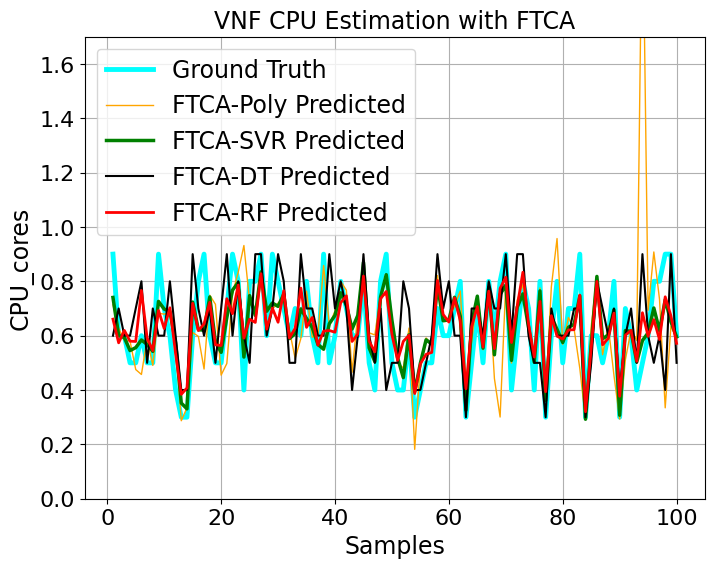

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan
"""

# Step 1 - Load TCA Data
######################################
X = Xs_new
y = Ys
x_t = Xt_new
x_t = x_t[0:100,:]
y_t = Yt[0:100,:]
#######################################
#Step2 Load Benchmark Origional Data

Xs = Xs
Xt = Xt[0:100,:]

################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)

#####Bencjmark poly#############
poly_features_2 = PolynomialFeatures(degree=4)
X_poly_2 = poly_features_2.fit_transform(Xs)

from sklearn.linear_model import LinearRegression
poly_regressor_2 = LinearRegression()
poly_regressor_2.fit(X_poly_2, y)

################################ model: poly_regressor_2


################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
X_scaled = ss_x.fit_transform(X)
y_scaled = ss_y.fit_transform(y.reshape(-1,1))


from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X_scaled, y_scaled)
#######SVR bench marks#######
svr_regressor_2 = SVR(kernel="rbf")
svr_regressor_2.fit(Xs, y)
############################### model: svr_regressor_2


################################
### Decision Tree Regression ###
################################
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor.fit(X, y)
####bench mark####

tree_regressor_2 = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor_2.fit(Xs, y)

##############################  model: tree_regressor_2

################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y)

#####bench mark####
forest_regressor_2 = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor_2.fit(Xs, y)

################################  model: forest_regressor_2

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))
plt.ylim(0, 1.7)

plt.plot(X_axis, y_t,color="cyan",label='Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

plt.plot(X_axis, poly_regressor.predict(poly_features.fit_transform(x_t)), color="orange",label='FTCA-Poly Predicted',lw=1)
#plt.plot(X_axis, poly_regressor_2.predict(poly_features_2.fit_transform(Xt)), color="orange",label='Poly Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, ss_y.inverse_transform(svr_regressor.predict(ss_x.transform(x_t)).reshape(-1,1)), color="green",label='FTCA-SVR Predicted',lw=2.5)
#plt.plot(X_axis, svr_regressor_2.predict(Xt), color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, tree_regressor.predict(x_t), color="black",label='FTCA-DT Predicted')
#plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

plt.plot(X_axis, forest_regressor.predict(x_t), color="red",label='FTCA-RF Predicted',lw=2)
#plt.plot(X_axis, forest_regressor_2.predict(Xt), color="red",label='RF Predicted',lw=1,linestyle = 'dotted')

#plt.xticks(np.arange(min(X), max(X)+1, 1))
#plt.yticks(np.arange(min(y), max(y)+1, 50000))
plt.rcParams['font.size'] = 17
plt.title("VNF CPU Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("CPU_cores",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-15-1fef6a8aae9b>:78: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor.fit(X, y)
<ipython-input-15-1fef6a8aae9b>:82: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor_2.fit(Xs, y)


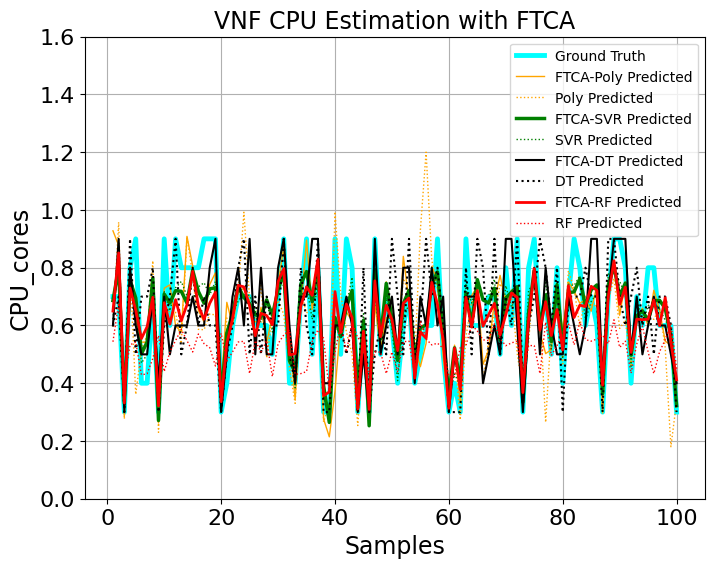

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan the label is CPU
"""

# Step 1 - Load TCA Data
######################################
X = Xs_new
y = Ys
x_t = Xt_new
x_t = x_t[0:100,:]
y_t = Yt[0:100,:]
#######################################
#Step2 Load Benchmark Origional Data

Xs = Xs
Xt = Xt[0:100,:]

################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)

#####Bencjmark poly#############
poly_features_2 = PolynomialFeatures(degree=4)
X_poly_2 = poly_features_2.fit_transform(Xs)

from sklearn.linear_model import LinearRegression
poly_regressor_2 = LinearRegression()
poly_regressor_2.fit(X_poly_2, y)

################################ model: poly_regressor_2


################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X, y)
#######SVR bench marks#######
svr_regressor_2 = SVR(kernel="linear")
svr_regressor_2.fit(Xs, y)
############################### model: svr_regressor_2


################################
### Decision Tree Regression ###
################################
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor.fit(X, y)
####bench mark####

tree_regressor_2 = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor_2.fit(Xs, y)

##############################  model: tree_regressor_2

################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y)

#####bench mark####
forest_regressor_2 = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor_2.fit(Xs, y)

################################  model: forest_regressor_2

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))
plt.ylim(0, 1.6)

plt.plot(X_axis, y_t,color="cyan",label='Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

plt.plot(X_axis, poly_regressor.predict(poly_features.fit_transform(x_t)), color="orange",label='FTCA-Poly Predicted',lw=1)
plt.plot(X_axis, poly_regressor_2.predict(poly_features_2.fit_transform(Xt)), color="orange",label='Poly Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, svr_regressor.predict(x_t), color="green",label='FTCA-SVR Predicted',lw=2.5)
plt.plot(X_axis, svr_regressor_2.predict(Xt),color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

plt.plot(X_axis, tree_regressor.predict(x_t), color="black",label='FTCA-DT Predicted')
plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

plt.plot(X_axis, forest_regressor.predict(x_t), color="red",label='FTCA-RF Predicted',lw=2)
plt.plot(X_axis, forest_regressor.predict(Xt), color="red",label='RF Predicted',lw=1,linestyle = 'dotted')

#plt.xticks(np.arange(min(X), max(X)+1, 1))
#plt.yticks(np.arange(min(y), max(y)+1, 50000))
#plt.rcParams['font.size'] = 16
plt.title("VNF CPU Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("CPU_cores",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare_CPU.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-5-8fb98373689e>:64: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor.fit(X, y)


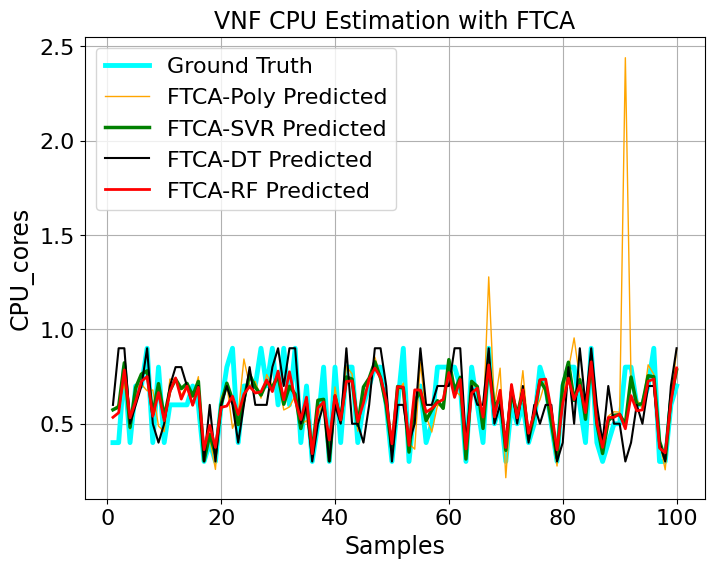

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan
"""

# Step 1 - Load Data

X = Xs_new
y = Ys


x_t = Xt_new
x_t = x_t[0:100,:]

y_t = Yt[0:100,:]


################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)


################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
X_scaled = ss_x.fit_transform(X)
y_scaled = ss_y.fit_transform(y.reshape(-1,1))


from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X_scaled, y_scaled)

################################
### Decision Tree Regression ###
################################
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor.fit(X, y)


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y)

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.figure(figsize=(8,6))

plt.plot(X_axis, y_t,color="cyan",label='Ground Truth',lw =3.5)
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')

plt.plot(X_axis, poly_regressor.predict(poly_features.fit_transform(x_t)), color="orange",label='FTCA-Poly Predicted',lw=1)

plt.plot(X_axis, ss_y.inverse_transform(svr_regressor.predict(ss_x.transform(x_t)).reshape(-1,1)), color="green",label='FTCA-SVR Predicted',lw=2.5)

plt.plot(X_axis, tree_regressor.predict(x_t), color="black",label='FTCA-DT Predicted')

plt.plot(X_axis, forest_regressor.predict(x_t), color="red",label='FTCA-RF Predicted',lw=2)

#plt.xticks(np.arange(min(X), max(X)+1, 1))
#plt.yticks(np.arange(min(y), max(y)+1, 50000))
plt.rcParams['font.size'] = 16
plt.title("VNF CPU Estimation with FTCA",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("CPU_cores",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-25-97528a1a05cc>:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regressor.fit(X, y)


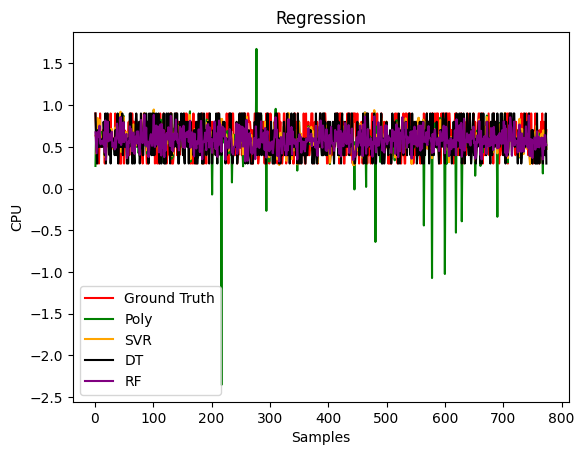

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  5 16:21:26 2023

@author: Dan
"""

# Step 1 - Load Data

X = Xs_new
y = Ys
x_t = Xt_new
y_t = Yt


################################
### Polynomial Regression ###
################################

# ** NOTE - conver X to X_poly of required degree
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
poly_regressor = LinearRegression()
poly_regressor.fit(X_poly, y)


################################
### SVR Regression ###
################################

# ** NOTE - SVR does not do feature scaling
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
X_scaled = ss_x.fit_transform(X)
y_scaled = ss_y.fit_transform(y.reshape(-1,1))


from sklearn.svm import SVR
svr_regressor = SVR(kernel="rbf")
svr_regressor.fit(X_scaled, y_scaled)

################################
### Decision Tree Regression ###
################################
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(criterion="friedman_mse")
tree_regressor.fit(X, y)


################################
### Random Forest Regression ###
################################
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
forest_regressor.fit(X, y)

################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np

################################
X_axis = np.arange(1,775,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################
plt.plot(X_axis, y_t,color="red",label='Ground Truth')
#plt.scatter(X_axis, y_t,color="red",label='Ground Truth')
plt.plot(X_axis, poly_regressor.predict(poly_features.fit_transform(x_t)), color="green",label='Poly')
plt.plot(X_axis, ss_y.inverse_transform(svr_regressor.predict(ss_x.transform(x_t)).reshape(-1,1)), color="orange",label='SVR')
plt.plot(X_axis, tree_regressor.predict(x_t), color="black",label='DT')
plt.plot(X_axis, forest_regressor.predict(x_t), color="purple",label='RF')
#plt.xticks(np.arange(min(X), max(X)+1, 1))
#plt.yticks(np.arange(min(y), max(y)+1, 50000))
plt.title("Regression")
plt.xlabel("Samples")
plt.ylabel("CPU")
#plt.figure(figsize=(20,10))
#fig = plt.gcf()
#fig.set_size_inches(10.5, 10)
plt.legend(loc='best')
plt.savefig('Regression compare.pdf', bbox_inches='tight')
plt.show()

In [ ]:
Xs

array([[0.33664234, 0.125     , 0.31077332, ..., 0.91557593, 0.10307047,
        0.16666667],
       [0.18656561, 0.75      , 0.20239606, ..., 0.84294757, 0.21147627,
        0.16666667],
       [0.79557592, 0.25      , 0.80999532, ..., 0.79862967, 0.7559127 ,
        0.        ],
       ...,
       [0.66584982, 0.125     , 0.765     , ..., 0.83834362, 0.70386569,
        1.        ],
       [0.25152356, 0.        , 0.26575086, ..., 0.84190662, 0.38701719,
        1.        ],
       [0.44084496, 0.5       , 0.52307561, ..., 0.91961891, 0.28907577,
        0.5       ]])

In [ ]:
Xt

array([[0.76041667, 0.25      , 0.7861525 , ..., 0.98267898, 0.92008359,
        0.66666667],
       [0.79166667, 0.25      , 0.82033304, ..., 0.69471709, 0.67269583,
        0.83333333],
       [0.29166667, 0.        , 0.30411919, ..., 0.85093023, 0.12870217,
        0.        ],
       ...,
       [0.41666667, 0.5       , 0.43382997, ..., 0.8874134 , 0.66757945,
        0.16666667],
       [0.29166667, 0.25      , 0.30324277, ..., 0.86593533, 0.10153491,
        0.5       ],
       [0.39583333, 0.875     , 0.41016652, ..., 0.91339492, 0.05080349,
        0.        ]])

In [ ]:
Xs_new

array([[-0.22611055,  0.28347347, -0.73813258, -0.08751776,  0.4450611 ,
        -0.34342156],
       [-0.39296399, -0.55905715, -0.26038268, -0.22608034,  0.37516605,
        -0.52285121],
       [-0.41243835,  0.15801955, -0.49884789, -0.34886877,  0.53266623,
        -0.38811401],
       ...,
       [ 0.56767937,  0.31938026, -0.36624367, -0.25401628,  0.37313328,
        -0.4876979 ],
       [ 0.65626876,  0.38286086, -0.24888498,  0.16842844,  0.4226587 ,
        -0.39214363],
       [ 0.1359785 , -0.16871009, -0.65464241, -0.10485669,  0.50647537,
        -0.50692981]])

In [ ]:
Xt_new

array([[ 0.16957821,  0.34343918, -0.30898316, -0.43774368,  0.52026855,
        -0.54362052],
       [ 0.474452  ,  0.22591677, -0.46516439, -0.34374927,  0.29758426,
        -0.54841504],
       [-0.65950189,  0.48340772, -0.36659507,  0.19743688,  0.09124649,
        -0.38687861],
       ...,
       [-0.47214496, -0.06979246, -0.22789421, -0.00363997,  0.66115286,
        -0.53210528],
       [ 0.09692484,  0.14314397, -0.68163591,  0.2535602 ,  0.37093293,
        -0.5510026 ],
       [-0.56825052, -0.41948036, -0.46319551,  0.3101177 ,  0.21082397,
        -0.38204419]])

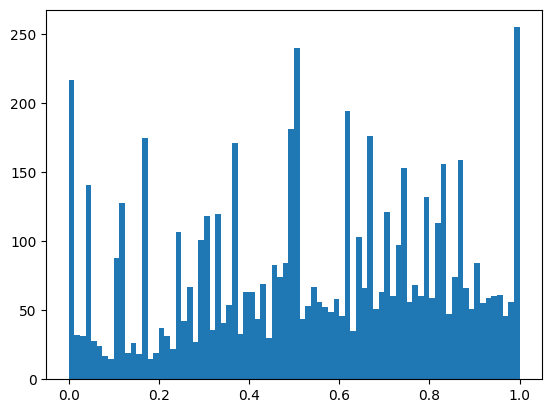

In [ ]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = Xt.flatten()
# plot a histogram of the sample
pyplot.hist(sample, bins=80)
pyplot.show()

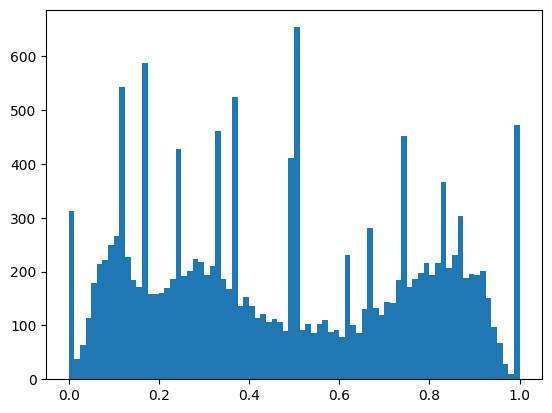

In [ ]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = Xs.flatten()
# plot a histogram of the sample
pyplot.hist(sample, bins=80)
pyplot.show()

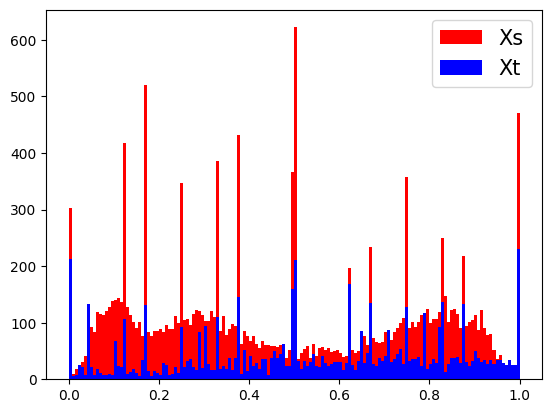

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXs = Xs.flatten()
img_flatXt = Xt.flatten()
#img_flatXt = np.random.choice(img_flatXt, 2200, replace=False)
n_bins = 150
xs_draw = [img_flatXs]
xt_draw = [img_flatXt]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
# colors = [ 'blue','red']
# labels = [ 'Xt','Xs']
plt.hist(xs_draw, n_bins, histtype='bar', stacked=True, color='red', label='Xs')
plt.hist(xt_draw, 150, histtype='bar', stacked=True, color='blue', label='Xt')
plt.legend(prop={'size': 15})
#plt.title('Probability Density')
plt.savefig('Raw_feature_distribution.pdf', bbox_inches='tight')
plt.show()

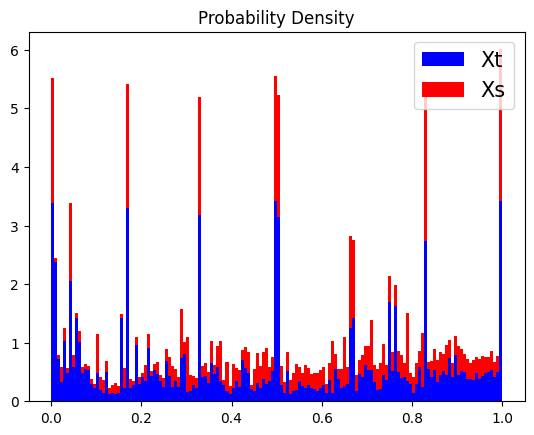

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXs = Xs.flatten()
img_flatXt = Xt.flatten()
n_bins = 150
x_draw = [img_flatXs, img_flatXt]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
colors = [ 'blue','red']
labels = [ 'Xt','Xs']
plt.hist(x_draw, n_bins, density=True, histtype='bar', stacked=True, color=colors, label=labels)
plt.legend(prop={'size': 15})
plt.title('Probability Density')
#plt.savefig('Digitfive_density.pdf', bbox_inches='tight')
plt.show()

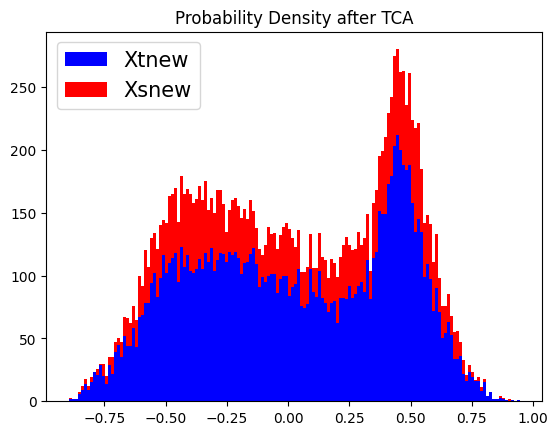

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXsnew = Xs_new.flatten()
img_flatXtnew = Xt_new.flatten()
n_bins = 150
x_draw = [img_flatXsnew, img_flatXtnew]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
colors = [ 'blue','red']
labels = [ 'Xtnew','Xsnew']
plt.hist(x_draw, n_bins, histtype='bar', stacked=True, color=colors, label=labels)
plt.legend(prop={'size': 15})
plt.title('Probability Density after TCA')
#plt.savefig('Digitfive_density.pdf', bbox_inches='tight')
plt.show()

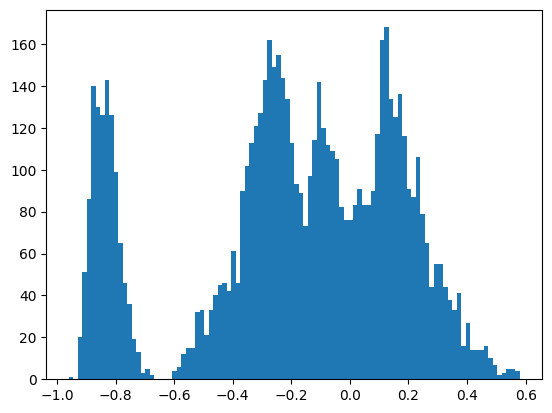

In [ ]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = Xs_new.flatten()
# plot a histogram of the sample
pyplot.hist(sample, bins=100)
pyplot.show()

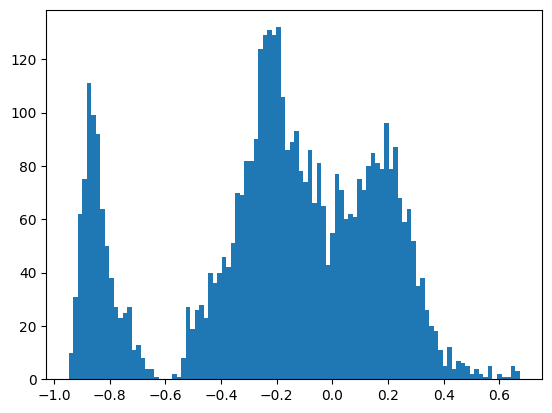

In [ ]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = Xt_new.flatten()
# plot a histogram of the sample
pyplot.hist(sample, bins=100)
pyplot.show()

In [ ]:
!unzip resnet50_feature.zip

Archive:  resnet50_feature.zip
 extracting: amazon_amazon.csv       
 extracting: amazon_dslr.csv         
 extracting: amazon_webcam.csv       
 extracting: dslr_amazon.csv         
 extracting: dslr_dslr.csv           
 extracting: dslr_webcam.csv         
 extracting: webcam_amazon.csv       
 extracting: webcam_dslr.csv         
 extracting: webcam_webcam.csv       


In [ ]:
# TCA 05/28

# encoding=utf-8


"""
    Created on 21:29 2018/11/12
    @author: Jindong Wang
"""
import numpy as np
import scipy.io
import scipy.linalg
import os
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier


def load_csv(folder, src_domain, tar_domain):
    data_s = np.loadtxt(f'{folder}/amazon_{src_domain}.csv', delimiter=',')
    data_t = np.loadtxt(f'{folder}/amazon_{tar_domain}.csv', delimiter=',')
    Xs, Ys = data_s[:, :-1], data_s[:, -1]
    Xt, Yt = data_t[:, :-1], data_t[:, -1]
    return Xs, Ys, Xt, Yt


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new


if __name__ == "__main__":
    folder = '.'
    src_domain = 'amazon'
    tar_domain = 'webcam'
    Xs, Ys, Xt, Yt = load_csv(folder, src_domain, tar_domain)
    print('Source:', src_domain, Xs.shape, Ys.shape)
    print('Target:', tar_domain, Xt.shape, Yt.shape)

    tca = TCA(kernel_type='primal', dim=40, lamb=0.1, gamma=1)
    acc, ypre, Xsnew, Xtnew = tca.fit_predict(Xs, Ys, Xt, Yt)
    print(f'Accuracy : {acc:.9f}')
    print(Xsnew)
    print(Xtnew)

Source: amazon (2817, 2048) (2817,)
Target: webcam (795, 2048) (795,)
Accuracy : 0.761006289
[[ 0.02458389  0.0212152   0.29503151 ... -0.13297531  0.05020103
   0.0440829 ]
 [-0.28777436  0.3351146  -0.2070156  ...  0.00475076  0.06936171
   0.04551725]
 [-0.20808918 -0.20851051 -0.31668484 ... -0.03687077  0.03344113
  -0.08528843]
 ...
 [-0.11964794  0.00407737 -0.21756844 ... -0.03684681 -0.06475623
  -0.15523329]
 [ 0.09705642  0.41268297  0.39689447 ... -0.07489374 -0.03558591
   0.08952569]
 [ 0.17012622 -0.39497755 -0.31888421 ... -0.09443562 -0.04853556
  -0.17841872]]
[[-0.04831004  0.08775029 -0.39184041 ... -0.24301189 -0.23583045
  -0.01315202]
 [-0.41649769  0.14099819  0.28650777 ... -0.0139072   0.03059567
   0.03726174]
 [ 0.33446581  0.05996176 -0.21752282 ... -0.10088575  0.17993472
   0.02670249]
 ...
 [ 0.19940962  0.32638805  0.3392112  ...  0.09148603  0.03438046
  -0.139538  ]
 [-0.34935103  0.11739923  0.00527653 ... -0.10665591  0.03305215
  -0.2872809 ]
 [-0.

In [ ]:
Xs

array([[0.011726, 1.928495, 0.467546, ..., 0.031908, 0.175205, 0.166139],
       [0.002589, 0.240411, 0.358171, ..., 0.601984, 0.795638, 0.693593],
       [0.019037, 0.509267, 1.413801, ..., 0.996922, 0.47772 , 0.262765],
       ...,
       [0.604223, 0.155129, 0.962526, ..., 0.292919, 0.050307, 0.026275],
       [0.077257, 0.218777, 0.282871, ..., 0.27124 , 0.200834, 0.550679],
       [0.112735, 0.063364, 0.117208, ..., 0.139828, 0.236973, 0.159019]])

In [ ]:
Xt

array([[4.727620e-01, 6.429040e-01, 3.715500e-01, ..., 2.886110e-01,
        9.680000e-04, 8.861800e-02],
       [7.102520e-01, 1.619362e+00, 2.076800e-01, ..., 1.330238e+00,
        1.516034e+00, 2.743200e-02],
       [2.431400e-02, 3.955700e-02, 3.818600e-02, ..., 2.813700e-02,
        3.343090e-01, 3.794880e-01],
       ...,
       [3.616940e-01, 1.647087e+00, 2.575400e-02, ..., 1.074600e-02,
        3.677290e-01, 1.288420e-01],
       [3.068000e-03, 2.820950e-01, 4.006490e-01, ..., 8.084070e-01,
        3.349460e-01, 7.185560e-01],
       [4.183500e-02, 4.451600e-02, 2.308060e-01, ..., 5.062820e-01,
        2.247453e+00, 2.877620e-01]])

In [ ]:
Xsnew

array([[ 0.02458389,  0.0212152 ,  0.29503151, ..., -0.13297531,
         0.05020103,  0.0440829 ],
       [-0.28777436,  0.3351146 , -0.2070156 , ...,  0.00475076,
         0.06936171,  0.04551725],
       [-0.20808918, -0.20851051, -0.31668484, ..., -0.03687077,
         0.03344113, -0.08528843],
       ...,
       [-0.11964794,  0.00407737, -0.21756844, ..., -0.03684681,
        -0.06475623, -0.15523329],
       [ 0.09705642,  0.41268297,  0.39689447, ..., -0.07489374,
        -0.03558591,  0.08952569],
       [ 0.17012622, -0.39497755, -0.31888421, ..., -0.09443562,
        -0.04853556, -0.17841872]])

In [ ]:
Xtnew

array([[-0.04831004,  0.08775029, -0.39184041, ..., -0.24301189,
        -0.23583045, -0.01315202],
       [-0.41649769,  0.14099819,  0.28650777, ..., -0.0139072 ,
         0.03059567,  0.03726174],
       [ 0.33446581,  0.05996176, -0.21752282, ..., -0.10088575,
         0.17993472,  0.02670249],
       ...,
       [ 0.19940962,  0.32638805,  0.3392112 , ...,  0.09148603,
         0.03438046, -0.139538  ],
       [-0.34935103,  0.11739923,  0.00527653, ..., -0.10665591,
         0.03305215, -0.2872809 ],
       [-0.24972924,  0.53241424,  0.03901837, ..., -0.09248208,
         0.00526768, -0.06854704]])

In [ ]:
def load_csv(src_domain, tar_domain):
  dfs = pd.read_csv(src_domain)
  dft = pd.read_csv(tar_domain)
  labels=['LINK']#CPU MEM LINK
  predictors = list(set(list(dfs.columns))-set(labels))
  norm_Xs = norm_scaler.fit_transform(dfs[predictors])
  norm_Xt = norm_scaler.fit_transform(dft[predictors])#normalization

  #norm_Xs.dropna(axis=0)
  dfs[labels].dropna(axis=0)
  #norm_Xt.dropna(axis=0)
  dft[labels].dropna(axis=0)

  Xs = norm_Xs
  Ys = dfs[labels].values
  Xt = norm_Xt
  Yt = dft[labels].values
  return Xs, Ys, Xt, Yt

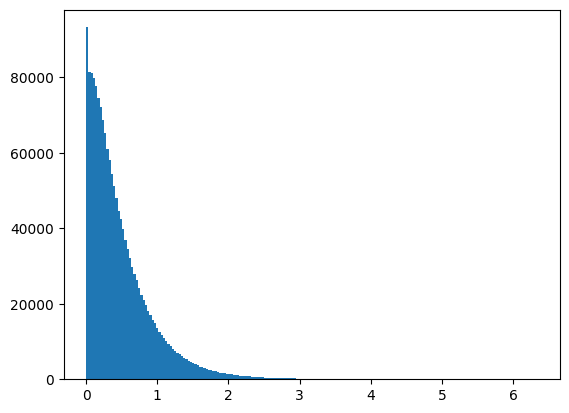

In [ ]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = Xt.flatten()
# plot a histogram of the sample
pyplot.hist(sample, bins=200)
pyplot.show()

Mean=50.126, Standard Deviation=4.929


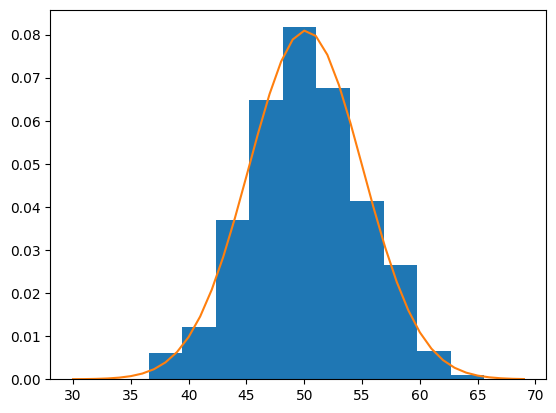

In [ ]:
# example of parametric probability density estimation
from matplotlib import pyplot
from numpy.random import normal
from numpy import mean
from numpy import std
from scipy.stats import norm
# generate a sample
sample = normal(loc=50, scale=5, size=1000)
# calculate parameters
sample_mean = mean(sample)
sample_std = std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
# define the distribution
dist = norm(sample_mean, sample_std)
# sample probabilities for a range of outcomes
values = [value for value in range(30, 70)]
probabilities = [dist.pdf(value) for value in values]
# plot the histogram and pdf
pyplot.hist(sample, bins=10, density=True)
pyplot.plot(values, probabilities)
pyplot.show()

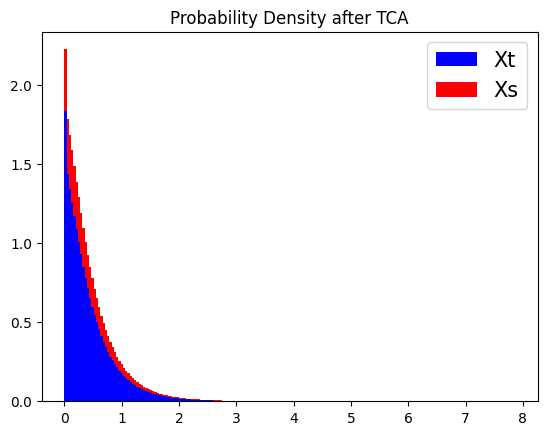

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXs = Xs.flatten()
img_flatXt = Xt.flatten()
n_bins = 200
x_draw = [img_flatXs.reshape(-1).tolist(), img_flatXt.reshape(-1).tolist()]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
colors = [ 'blue','red']
labels = [ 'Xt','Xs']
plt.hist(x_draw, n_bins, density=True, histtype='bar', stacked=True, color=colors, label=labels)
plt.legend(prop={'size': 15})
plt.title('Probability Density after TCA')
#plt.savefig('Digitfive_density.pdf', bbox_inches='tight')
plt.show()

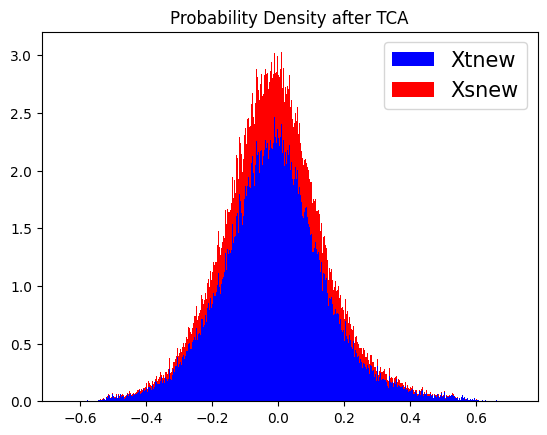

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color
img_flatXsnew = Xsnew.flatten()
img_flatXtnew = Xtnew.flatten()
n_bins = 600
lists = img_flatXsnew.reshape(-1).tolist()
listt = img_flatXtnew.reshape(-1).tolist()
#listt = listt[1:31800]
x_draw = [lists, listt]
#plt.xticks(fontsize=22)
##plt.yticks(fontsize=34)#
colors = [ 'blue','red']
labels = [ 'Xtnew','Xsnew']
plt.hist(x_draw, n_bins, density=True, histtype='bar', stacked=True, color=colors, label=labels)
plt.legend(prop={'size': 15})
plt.title('Probability Density after TCA')
#plt.savefig('Digitfive_density.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# encoding=utf-8
"""
    Created on 21:29 2018/11/12
    @author: Jindong Wang
"""
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1 = Xt2, X2 = X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new   = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred



if __name__ == '__main__':
    domains = ['caltech.mat', 'amazon.mat', 'webcam.mat', 'dslr.mat']
    for i in [1]:
        for j in [2]:
            if i != j:
                src, tar = 'data/' + domains[i], 'data/' + domains[j]
                src_domain, tar_domain = scipy.io.loadmat(src), scipy.io.loadmat(tar)
                Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['label'], tar_domain['feas'], tar_domain['label']

                # Split target data
                Xt1, Xt2, Yt1, Yt2  = train_test_split(Xt, Yt, train_size=50, stratify=Yt, random_state=42)

                # Create latent space and evaluate using Xs and Xt1
                tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
                acc1, ypre1 = tca.fit_predict(Xs, Ys, Xt1, Yt1)

                # Project and evaluate Xt2 existing projection matrix and classifier
                acc2, ypre2 = tca.fit_predict_new(Xt1, Xs, Ys, Xt2, Yt2)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}') #0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}') #0.706

Accuracy of mapped source and target1 data : 0.400
Accuracy of mapped target2 data            : 0.371


In [ ]:
src_domain

In [ ]:
src_domain

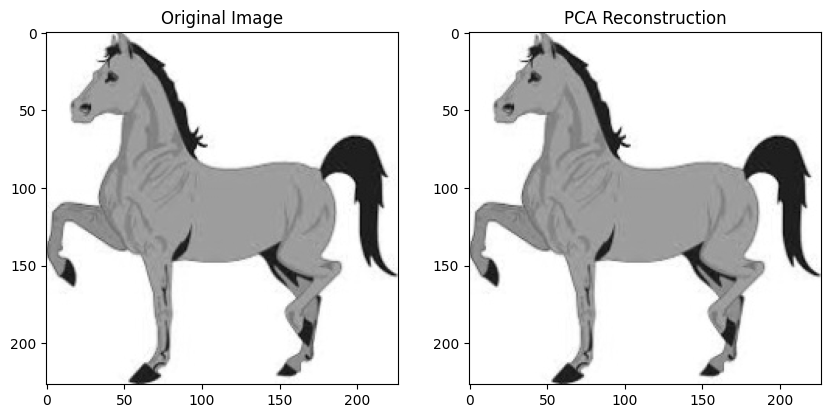

array([5.66781935e-03, 1.41695484e-02, 2.83390967e-02, 5.10103741e-02,
       9.21020644e-02, 2.08292361e-01, 4.29337315e-01, 9.02600231e-01,
       1.29651368e+00, 3.64157393e-01, 1.44529393e-01, 1.14773342e-01,
       6.65968773e-02, 4.81764644e-02, 7.22646967e-02, 6.09290580e-02,
       7.36816515e-02, 7.22646967e-02, 4.81764644e-02, 3.82577806e-02,
       6.65968773e-02, 5.80951483e-02, 8.50172902e-02, 6.51799225e-02,
       4.67595096e-02, 7.79325160e-02, 9.91868385e-02, 8.64342450e-02,
       1.07688568e-01, 1.43112438e-01, 1.91288903e-01, 2.60719690e-01,
       4.13750812e-01, 7.94911663e-01, 9.67780153e-01, 9.84783611e-01,
       1.08963827e+00, 9.94702295e-01, 1.10947564e+00, 1.96248245e+00,
       8.47480688e+00, 2.27137860e+00, 4.73262915e-01, 1.61532851e-01,
       9.06851095e-02, 7.93494708e-02, 7.50986063e-02, 6.65968773e-02,
       5.10103741e-02, 5.52612386e-02, 8.78511999e-02, 6.80138321e-02,
       6.94307870e-02, 6.23460128e-02, 7.50986063e-02, 7.08477418e-02,
      

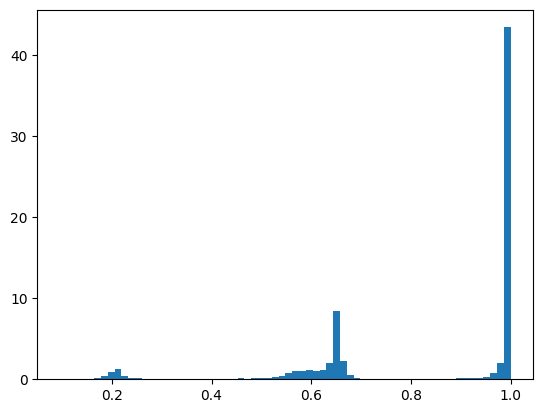

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color

# 加载图像
img = io.imread(r"/content/cartoonhorse")

# 将图像转换为灰度图像
img_gray = color.rgb2gray(img)

# 将图像展平为一维数组
img_flat = img_gray.flatten()

# 对图像进行PCA降维
pca = PCA(n_components=0.95, whiten=True, random_state=40)
img_pca = pca.fit_transform(img_flat.reshape(-1, 1))

# 对降维后的图像进行反变换，得到原始图像矩阵
img_rec = pca.inverse_transform(img_pca)
img_rec = img_rec.reshape(img_gray.shape)

# 绘制原始图像和降维后的图像
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray, cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(img_rec, cmap="gray")
ax[1].set_title("PCA Reconstruction")
plt.show()
#plt.hist(img_flat, bins='auto', label = 'image for distribution')
prob1, bins, pacthes= plt.hist(img_flat, bins=66, density=True, label = 'image one')
prob1

plt.hist(img_pca, bins='auto', label = 'image one')

#prob1, bins, pacthes= plt.hist(img_flat, bins='auto', density=True, label = 'image one')

prob1

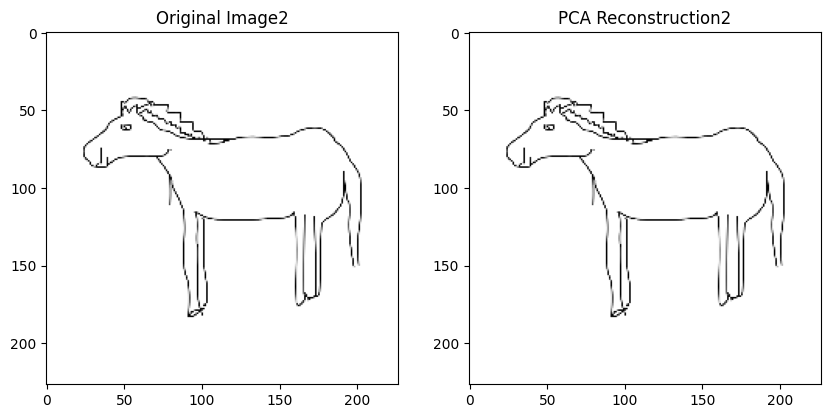

array([7.05738516e-01, 4.99524540e-02, 3.20208038e-02, 2.81783074e-02,
       2.30549787e-02, 2.43358109e-02, 2.30549787e-02, 1.28083215e-02,
       2.81783074e-02, 2.04933144e-02, 1.66508180e-02, 2.81783074e-02,
       1.66508180e-02, 1.15274894e-02, 1.40891537e-02, 1.28083215e-02,
       1.66508180e-02, 1.66508180e-02, 1.92124823e-02, 1.92124823e-02,
       2.04933144e-02, 1.02466572e-02, 1.15274894e-02, 2.30549787e-02,
       1.79316501e-02, 1.66508180e-02, 1.53699858e-02, 8.96582507e-03,
       1.66508180e-02, 1.15274894e-02, 1.28083215e-02, 1.40891537e-02,
       1.15274894e-02, 1.53699858e-02, 1.15274894e-02, 1.28083215e-02,
       7.68499292e-03, 1.92124823e-02, 1.28083215e-02, 2.30549787e-02,
       1.66508180e-02, 1.53699858e-02, 1.92124823e-02, 2.43358109e-02,
       1.28083215e-02, 1.66508180e-02, 2.17741466e-02, 1.79316501e-02,
       1.92124823e-02, 2.30549787e-02, 1.79316501e-02, 1.53699858e-02,
       2.04933144e-02, 2.04933144e-02, 1.79316501e-02, 1.79316501e-02,
      

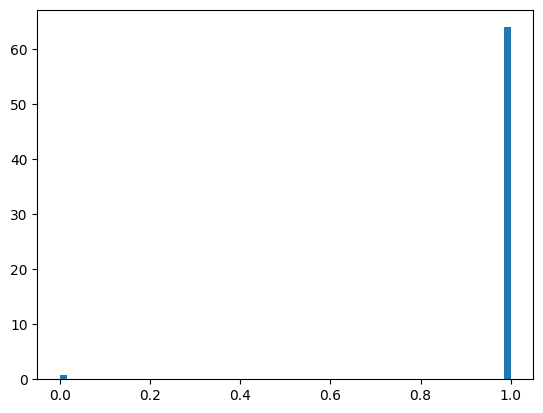

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import io, color

# 加载图像
img2 = io.imread(r"/content/sketchhorse")

# 将图像转换为灰度图像
img_gray2 = color.rgb2gray(img2)

# 将图像展平为一维数组
img_flat2 = img_gray2.flatten()

# 对图像进行PCA降维
pca2 = PCA(n_components=0.01, whiten=True, random_state=40)
img_pca2 = pca2.fit_transform(img_flat2.reshape(-1, 1))

# 对降维后的图像进行反变换，得到原始图像矩阵
img_rec2 = pca2.inverse_transform(img_pca2)
img_rec2 = img_rec2.reshape(img_gray2.shape)

# 绘制原始图像和降维后的图像
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray2, cmap="gray")
ax[0].set_title("Original Image2")
ax[1].imshow(img_rec2, cmap="gray")
ax[1].set_title("PCA Reconstruction2")
plt.show()
#plt.hist(img_flat, bins='auto', label = 'image for distribution')
prob2, bins2, pacthe2= plt.hist(img_flat2, bins=66, density=True, label = 'image two')
prob2

In [ ]:
from scipy.stats import entropy #information loss use artpainting to describe photo

entropy(prob1, prob2)

0.4567275694254575

In [ ]:
from scipy.stats import entropy #imformation loss use photo to describe artpainting

entropy(prob2, prob1)

0.41098893349375676

In [ ]:
import numpy as np
from scipy.stats import entropy
qk = np.array([9/10, 1/10])
pk = np.array([1/2, 1/2])
D_q_to_p = entropy(pk, qk)#big, information loss use abnoral coin to describe normal coin
D_p_to_q = entropy(qk, pk)#small information loss use normal coin to describe aabnormal coin
print(D_q_to_p)
print(D_p_to_q)

0.5108256237659907
0.3680642071684971


In [ ]:
from scipy.stats import entropy #information loss use sketch to describe cartoon

entropy(prob1, prob2)

1.445202928495744

In [ ]:
from scipy.stats import entropy #imformation loss use cartoon to describe sketch

entropy(prob2, prob1)

0.4909894264328875

so the final generalization is sketch > cartoon > artpainting > photo

In [ ]:
##CORAL 2023/05/28

# encoding=utf-8
"""
    Created on 16:31 2018/11/13
    @author: Jindong Wang
"""

import numpy as np
import scipy.io
import os
import scipy.linalg
import sklearn.metrics
import sklearn.neighbors


def load_csv(folder, src_domain, tar_domain):
    data_s = np.loadtxt(f'{folder}/amazon_{src_domain}.csv', delimiter=',')
    data_t = np.loadtxt(f'{folder}/amazon_{tar_domain}.csv', delimiter=',')
    Xs, Ys = data_s[:, :-1], data_s[:, -1]
    Xt, Yt = data_t[:, :-1], data_t[:, -1]
    return Xs, Ys, Xt, Yt


class CORAL:
    def __init__(self):
        super(CORAL, self).__init__()

    def fit(self, Xs, Xt):
        '''
        Perform CORAL on the source domain features
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: New source domain features
        '''
        cov_src = np.cov(Xs.T) + np.eye(Xs.shape[1])
        cov_tar = np.cov(Xt.T) + np.eye(Xt.shape[1])
        A_coral = np.dot(
            scipy.linalg.fractional_matrix_power(cov_src, -0.5),
            scipy.linalg.fractional_matrix_power(cov_tar, 0.5))
        Xs_new = np.real(np.dot(Xs, A_coral))
        return Xs_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Perform CORAL, then predict using 1NN classifier
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted labels of target domain
        '''
        Xs_new = self.fit(Xs, Xt)
        clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred


if __name__ == "__main__":
    folder = './office31_resnet50'
    src_domain = 'amazon'
    tar_domain = 'dslr'
    Xs, Ys, Xt, Yt = load_csv(folder, src_domain, tar_domain)
    print('Source:', src_domain, Xs.shape, Ys.shape)
    print('Target:', tar_domain, Xt.shape, Yt.shape)
    coral = CORAL()
    acc, ypre = coral.fit_predict(Xs, Ys, Xt, Yt)
    print(f'Accuracy: {acc:.9f}')

Source: amazon (2817, 2048) (2817,)
Target: dslr (498, 2048) (498,)
Accuracy: 0.751004016


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
norm_scaler = MinMaxScaler()

src_domain = '/content/Inline.csv'
tar_domain = '/content/Passive.csv'

dfs = pd.read_csv(src_domain)
dft = pd.read_csv(tar_domain)


labels=['LINK']#CPU MEM LINK
predictors = list(set(list(dfs.columns))-set(labels))
norm_Xs = norm_scaler.fit_transform(dfs[predictors])
norm_Xt = norm_scaler.fit_transform(dft[predictors])#normalization

#norm_Xs.dropna(axis=0)
dfs[labels].dropna(axis=0)
#norm_Xt.dropna(axis=0)
dft[labels].dropna(axis=0)

Xs = norm_Xs
Ys = dfs[labels].values

Xt = norm_Xt
Yt = dft[labels].values

In [ ]:
# encoding=utf-8
"""
    Created on 21:29 2018/11/12
    @author: Jindong Wang
"""
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1 = Xt2, X2 = X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new   = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred



if __name__ == '__main__':
    domains = ['caltech_decaf.mat', 'amazon_decaf.mat', 'webcam_decaf.mat', 'dslr_decaf.mat']
    for i in [1]:
        for j in [2]:
            if i != j:
                src, tar = 'data2/' + domains[i], 'data2/' + domains[j]
                src_domain, tar_domain = scipy.io.loadmat(src), scipy.io.loadmat(tar)
                Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['labels'], tar_domain['feas'], tar_domain['labels']

                # Split target data
                Xt1, Xt2, Yt1, Yt2  = train_test_split(Xt, Yt, train_size=50, stratify=Yt, random_state=42)

                # Create latent space and evaluate using Xs and Xt1
                tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
                acc1, ypre1 = tca.fit_predict(Xs, Ys, Xt1, Yt1)

                # Project and evaluate Xt2 existing projection matrix and classifier
                acc2, ypre2 = tca.fit_predict_new(Xt1, Xs, Ys, Xt2, Yt2)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}') #0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}') #0.706

Accuracy of mapped source and target1 data : 0.800
Accuracy of mapped target2 data            : 0.706
